<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/code/SV/5s/SV_unet_projection_guanape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Guanape

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import *

## Load model

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.threshold = nn.Sequential(
#             nn.BatchNorm2d(1),
            nn.Conv2d(1, 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.cnn_input_1 = nn.Sequential(
            nn.BatchNorm1d(8+3),
            nn.Conv1d(8+3, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 5, stride = 2, padding = 2, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_2 = nn.Sequential(
             nn.ConvTranspose1d(32, 16, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )

        self.cnn_output_2 = nn.Sequential(
            nn.BatchNorm1d(16*2),
            nn.Conv1d(16*2, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.upconv_1 = nn.Sequential(
             nn.ConvTranspose1d(16, 8, kernel_size = 6, stride = 2, padding = 2, dilation = 1)
         )
        
        self.cnn_output_1 = nn.Sequential(
            nn.BatchNorm1d(8*2),
            nn.Conv1d(8*2, 8,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(4, 2, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(2, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1)
        )

    def forward(self, x, y):
        out = self.threshold(y)
        out = torch.sum(out, 2)

        out = torch.cat((out, x.squeeze(1)), 1)

        out_1 = self.cnn_input_1(out)
        out = self.pooling_1(out_1)
        out_2 = self.cnn_input_2(out)
        out = self.pooling_2(out_2)
        out = self.cnn_input_3(out)

        out = self.upconv_2(out)
        out = torch.cat((out, out_2), 1)
        out = self.cnn_output_2(out)

        out = self.upconv_1(out)
        out = torch.cat((out, out_1), 1)
        out = self.cnn_output_1(out)


        return out

def get_score(out, y):
    out, y = out.cpu(), y.cpu()
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))



In [6]:
model = torch.load('SV_unet_matrixlonlatcov_5s.pt')
window = 20
variable = ('lon_std', 'lat_std', 'gaps')

# Fine-tuning

In [7]:
# # select only two trips

# train_trajs = data_test_new.trip.unique()[0:5]
# data_train_new = data_test_new[data_test_new.trip.isin(train_trajs)]

# validation_trajs = data_test_new.trip.unique()[5:len(data_test_new.trip.unique())]
# data_validation_new = data_test_new[data_test_new.trip.isin(validation_trajs)]

In [8]:
# # hyperparameters
# batch_size = 64

# ## reduce size dataset
# train_set = TrajDataSet(data_train_new, window, variable, transform = ToTensor())
# validation_set = TrajDataSet(data_validation_new, window, variable, transform = ToTensor())

# train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
# validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [ ]:
# # Loss and score
# learning_rate = 0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# weight = torch.FloatTensor([30])
# criterion = nn.BCEWithLogitsLoss(pos_weight = weight)

In [ ]:
# # Train the model
# nb_epoch = 5
    
# for epoch in range(nb_epoch):
#     learning_rate /= 10
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     for batch, (x, y, z) in enumerate(train_loader):

#         # Run the forward pass
#         out = model(x, y)
#         loss = criterion(out, z)
        
#         # Backprop and perform optimisation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     ### Evaluation
#     model.eval()
#     with torch.no_grad():     
#         # evaluation
#         list_loss_train = []
#         list_score_train = []
#         for batch, (x, y, z) in enumerate(train_loader):

#             # Run the forward pass
#             out =  model(x, y)
#             loss = criterion(out, z)

#             list_loss_train.append(loss.item())
            
#         train_loss = np.mean(list_loss_train)
       

#     print('Epoch [{}/{}] -------------------------------------------------------------------------------------'
#       .format(epoch+1, nb_epoch))
#     print('Train Loss: {}'
#             .format(round(train_loss, 2)))
#     model.train()

# Test

In [7]:
data_train = pd.read_csv('./data/SV_train.csv')
data_validation = pd.read_csv('./data/SV_validation.csv')
data_test = pd.read_csv('./data/SV_test.csv')
data_test_guanape = pd.read_csv('./data/SV_test_guanape.csv')

data = pd.concat([data_train, data_validation, data_test, data_test_guanape])

In [10]:
resolution = 5
data_new = change_resolution(data, resolution)
data_new = standardize_data(data_new)

data_new.head()

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_46_SV_T4,2008-12-06 16:06:25,-77.265897,-11.774297,0.0,0,15.301035,26.025648,2.309584,0.788287,0.826924,0.898598,0.438773
3,P1108_46_SV_T4,2008-12-06 16:06:30,-77.266435,-11.774462,0.0,0,12.287117,-18.228550,2.293957,0.776022,0.663327,0.949816,-0.312808
4,P1108_46_SV_T4,2008-12-06 16:06:35,-77.266843,-11.774868,0.0,0,12.679214,-28.073536,2.282105,0.745841,0.684610,0.882344,-0.470604
5,P1108_46_SV_T4,2008-12-06 16:06:40,-77.267200,-11.775312,0.0,0,12.579325,-6.324066,2.271735,0.712835,0.679188,0.993915,-0.110152
6,P1108_46_SV_T4,2008-12-06 16:06:45,-77.267390,-11.775845,0.0,0,12.567659,-18.969971,2.266216,0.673214,0.678555,0.945689,-0.325073


In [11]:
dive_estim = []

for i in data_new.trip.unique():
    # create dataset for a trajectory
    t = data_new[data_new.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = ToTensor())
    
    # Test the model
    estim = np.zeros(len(t))
    nb = np.zeros(len(t))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y, z) in test_set:

            # Run the forward pass
            out = model(x, y.unsqueeze(1))
            
            estim[k:k + round(window)] += out.cpu().squeeze().numpy()
            nb[k:k + round(window)] += 1
            k+=1
    # # add to list by trajectory
    dive_estim.append(estim/nb)
    print(i)

data_new['prediction'] = 1/(1+np.exp(-np.hstack(dive_estim)))

P1108_46_SV_T4
P1108_4_SV_T1
P1108_4_SV_T2
P1108_6_SV_T1
P1109_21_SV_T4
P1109_21_SV_T7
P1111_27_SV_T2
P1111_27_SV_T4
P1111_41_SV_T1
P1111_41_SV_T4
P1111_46_SV_T5
P1111_9_SV_T2
P1112_10_SV_T1
P1112_11_SV_T7
P1112_12_SV_T1
P1112_12_SV_T4
P1112_14_SV_T1
P1112_14_SV_T2
P1112_15_SV_T1
P1112_15_SV_T2
P1112_15_SV_T3
P1112_15_SV_T4
P1112_18_SV_T2
P1112_18_SV_T3
P1112_18_SV_T5
P1112_19_SV_T2
P1112_19_SV_T3
P1112_19_SV_T4
P1112_19_SV_T5
P1112_19_SV_T6
P1112_19_SV_T7
P1112_20_SV_T1
P1112_20_SV_T2
P1112_20_SV_T3
P1112_21_SV_T1
P1112_21_SV_T2
P1112_22_SV_T1
P1112_22_SV_T2
P1112_22_SV_T3
P1112_24_SV_T1
P1112_24_SV_T3
P1112_24_SV_T4
P1112_25_SV_T1
P1112_25_SV_T3
P1112_25_SV_T4
P1112_25_SV_T5
P1112_26_SV_T3
P1112_27_SV_T1
P1112_27_SV_T2
P1112_29_SV_T2
P1112_29_SV_T3
P1112_30_SV_T1
P1112_30_SV_T2
P1112_31_SV_T1
P1112_31_SV_T2
P1112_31_SV_T5
P1112_33_SV_T2
P1112_34_SV_T1
P1112_35_SV_T2
P1112_37_SV_T1
P1112_37_SV_T2
P1112_37_SV_T3
P1112_38_SV_T1
P1112_38_SV_T2
P1112_3_SV_T2
P1112_4_SV_T2
P1112_4_SV_T4
P1

In [21]:
data_test_new = data_new[[x[0] == 'G' for x in data_new.trip]]

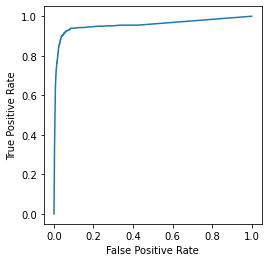

In [22]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')


# globally
TP = []
FP = []

for tt in np.arange(0,1,0.001):
    all_estim = 1* (data_test_new.prediction > tt)
    true_positive = np.mean(all_estim[data_test_new.dive == 1])
    true_negative = 1-np.mean(all_estim[data_test_new.dive == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

plt.plot(np.array(FP), np.array(TP))

# Export Probabilities

In [23]:
data_new.to_csv('SV_unet_projection.csv', index = False)